## Train ReLayNet
RunFile of OCT segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from pathlib import Path
#ECG: you will also need to install h5py in the conda env

from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.data_utils import get_imdb_data

#originally commented out 
#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
##ECG
# path_dataset = Path("C:/Users/econtrerasguzman/Desktop/development/skala_lab/projects/placenta_oct_(Kayvan)/relaynet_pytorch-master/ecg_small_dataset")

# original duke dataset
# path_dataset = Path("C:/Users/econtrerasguzman/Desktop/data/relaynet/2015_BOE_Chiu/h5")
#suffix = '' # regular size 
# suffix = "_small" # reduced size for testing, 5 training 5 testing

# small oct dataset
path_dataset = Path("Z:/0-Projects and Experiments/KS - OCT membranes/oct_dataset_3100x256/0-other_files/h5_dataset_files/ecg_small_dataset")
suffix = '_ecg'

# these lines prevent the error
# RuntimeError: Sizes of tensors must match except in dimension 3. Got 166 and 167 (The offending index is 0)
# which seems like an input size/dimension mismatch
row_upper_limit = 256 # 256
column_lower_limit = 100 # 3000 size

train_data, test_data = get_imdb_data(path_dataset, suffix,row_upper_limit,column_lower_limit )

### ECG objects should have format: 
# X = (176, 1, 435, 768) [num_image, channel, rows, cols]
# y (176, 435, 768) [num_image, rows, cols]
# w (176, 10, 435, 768) [num_image, num_layers, rows, cols]
print(f"train X : {train_data.X.shape}")
print(f"train y : {train_data.y.shape}")
print(f"train w : {train_data.w.shape}")
###

print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

train X : (2, 1, 256, 3000)
train y : (2, 256, 3000)
train w : (2, 10, 256, 3000)
Train size: 2
Test size: 3


In [3]:
from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)

param ={
        'num_channels':1,
        'num_filters':64,
        'kernel_h':3,
        'kernel_w':7,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_class': 10 # ECG: was originally 9
    }

exp_dir_name = 'Exp01'

import sys
print(sys.version)

relaynet_model = ReLayNet(param)
solver = Solver(optim_args={"lr": 1e-2})
solver.train(relaynet_model, train_loader, val_loader, log_nth=1, num_epochs=1, exp_dir_name=exp_dir_name)


### ECG
# in order to change conda environment in jupyter notebook you need to install nb_conda
####
#Scratch this, you need python 3.8 as this was resolved then
# in order to resolve: OverflowError: cannot serialize a bytes object larger than 4 GiB
# Update like 58
# C:\ProgramData\Anaconda3\lib\multiprocessing\reduction.py in dump(obj, file, protocol)
#      58 def dump(obj, file, protocol=4): # originallyit was this--> def dump(obj, file, protocol=None):
#      59     '''Replacement for pickle.dump() using ForkingPickler.'''
# ---> 60     #ForkingPickler(file, protocol).dump(obj)

# Source: https://stackoverflow.com/questions/29704139/pickle-in-python3-doesnt-work-for-large-data-saving
###
# First install visual studio
# Then Install CUDA toolkit
# https://developer.nvidia.com/cuda-downloads
###

C:\ProgramData\Anaconda3\envs\relaynet\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


3.8.5 (default, Aug  5 2020, 09:44:06) [MSC v.1916 64 bit (AMD64)]
cuda is available
START TRAIN.


C:\ProgramData\Anaconda3\envs\relaynet\lib\site-packages\torch\optim\lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


X size: torch.Size([1, 1, 256, 3000])
X size: torch.Size([1, 1, 256, 3000])
[Epoch : 0/1] : tensor(4.0736, device='cuda:0')
Saving model... models/Exp01/relaynet_epoch1.model
FINISH.


## Save the Model

When you are satisfied with your training, you can save the model.

In [4]:
relaynet_model.save("models/relaynet_model.model")

Saving model... models/relaynet_model.model


# Deploy Model on Test Data

In [5]:
SEG_LABELS_LIST = [
    {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
    {"id": 0, "name": "Region above the retina (RaR)", "rgb_values": [128, 0, 0]},
    {"id": 1, "name": "ILM: Inner limiting membrane", "rgb_values": [0, 128, 0]},
    {"id": 2, "name": "NFL-IPL: Nerve fiber ending to Inner plexiform layer", "rgb_values": [128, 128, 0]},
    {"id": 3, "name": "INL: Inner Nuclear layer", "rgb_values": [0, 0, 128]},
    {"id": 4, "name": "OPL: Outer plexiform layer", "rgb_values": [128, 0, 128]},
    {"id": 5, "name": "ONL-ISM: Outer Nuclear layer to Inner segment myeloid", "rgb_values": [0, 128, 128]},
    {"id": 6, "name": "ISE: Inner segment ellipsoid", "rgb_values": [128, 128, 128]},
    {"id": 7, "name": "OS-RPE: Outer segment to Retinal pigment epithelium", "rgb_values": [64, 0, 0]},
    {"id": 8, "name": "Region below RPE (RbR)", "rgb_values": [192, 0, 0]}];
    #{"id": 9, "name": "Fluid region", "rgb_values": [64, 128, 0]}];
    
def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

<ipython-input-6-4966ab39f334>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  out = relaynet_model(Variable(torch.Tensor(test_data.X[0:1]).cuda(),volatile=True))


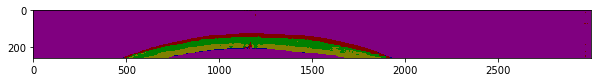

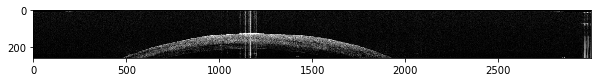

In [6]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

relaynet_model =  torch.load('models/Exp01/relaynet_epoch20.model')
out = relaynet_model(Variable(torch.Tensor(test_data.X[0:1]).cuda(),volatile=True))
out = F.softmax(out,dim=1)
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = label_img_to_rgb(idx)
plt.imshow(idx)
plt.show()

img_test = test_data.X[0:1]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.show()